In [16]:
from glob import glob

scores = {"intersec": {}, "algnWoutOffs": {}}

#Iterate over simulation results
for m in scores.keys():
    for f in glob(f"../simulations/scores_mes{m}_s20620220951_n100_l10008_m*.txt"):
        #Parse mutation rate from file name
        mRate = float(f.split("_m")[2].split("_i")[0])
        #Initialize a score list for each mutation rate
        scores[m][mRate] = []

        for l in open(f, 'r'):
            scores[m][mRate].append(int(l))

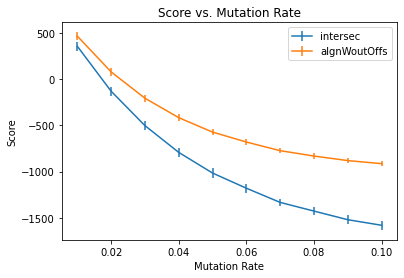

In [17]:
from matplotlib import pyplot as plt
from numpy import mean, std

rateRange = sorted(scores["algnWoutOffs"].keys())

for m in scores.keys():
    plt.errorbar(rateRange, [mean(scores[m][r]) for r in rateRange], yerr=[std(scores[m][r]) for r in rateRange], \
                label=m)
    
plt.title("Score vs. Mutation Rate")
plt.xlabel("Mutation Rate")
plt.ylabel("Score")
plt.legend()
plt.show()

# Homology Scores

In [1]:
#Mapping between a nucleotide character and its bitwise representation
NT_IN_BITS = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

#This function calculates the hash of a bitwise k-mer representation. The function is influenced by the code of "The minimizer Jaccard estimator is 
#biased and inconsistent." from Belbasi et al. (function "minimap2_hash(seed,v,mask)" in file "minimap2_hash_uncompiled.py").
def getHash(kmer, mask):
    u = kmer & mask
    u = ((~u) + (u << 21)) & mask # u = (u<<21)-(u+1) = 77594587*u-1
    u = u ^ (u >> 24)
    u = ((u + (u << 3)) + (u << 8)) & mask # u *= 265
    u = u ^ (u >> 14)
    u = ((u + (u << 2)) + (u << 4)) & mask # u *= 21
    u = u ^ (u >> 28)
    u = (u + (u << 31)) & mask # u *= 2147483649

    return u

#This function calculates the sketch of a sequence. It is influenced by the code of "The minimizer Jaccard estimator is biased and inconsistent."
#from Belbasi et al. (function "hash_sequence(seq,kmerSize,hashFunc,canonical=False)" in file "jaccard_correction_test.py").
def calcSketch(seq, k, thres):
    sketch = []

    #Calculate mask
    mask = (4 ** k) - 1

    #Iterate of all k-mers in sequence
    for i in range(len(seq) - k + 1):
        kmerBits = 0

        #Get bit representation of k-mer
        for c in seq[i:i+k]:
            kmerBits = (kmerBits << 2) + NT_IN_BITS[c]

        #Calculate hash
        kmerHash = getHash(kmerBits, mask)

        #Add hash to sketch if it is small enough
        if kmerHash <= thres:
            sketch.append((i, kmerHash))

    return sketch

In [46]:
from glob import glob
from math import floor

#K-mer length
K = 9
#Dictionary to store sketches of all texts
textSketches = {}
    
#Calculate sketches of sequences
for f in glob("../simulations/searchPairs_gn100_rn400_gl1000_rl500_o3_m0*"):
    #Get mutation rate
    mRate = float(f.split("_m")[1].split("_i")[0])
    #Initialize new list
    textSketches[mRate] = []
    #Calculate hash threshold
    thres = floor(((4 ** K) - 1) * 0.1)
    
    for l in open(f, 'r'):
        textSketches[mRate].append(calcSketch(l.strip().split(' ')[1], K, thres))

In [53]:
##Load found t-homologies##

#A dictionary for all scores
scores = {}
#A dictionary to store the number ob found t-homologies per pair
homsPerPair = {}
#A dictionary to store the percentage of coverage of real homologies by t-homologies
percCovs = {}
#A dictionary to store start end stop positions of all t-homologies
coords = {}

for f in glob("../simulations/homologies_gn100_rn400_gl1000_rl500_o3_m0*"):
    #Get mutation rate
    mRate = float(f.split("_m")[1].split("_i")[0])
    lastPairID = 1
    nbHoms = 0
    
    #Initialize new lists
    for d in scores, homsPerPair, percCovs, coords:
        d[mRate] = []
    
    for l in open(f, 'r'):
        l.strip()
        
        if l.startswith("Pair"):
            pairID = int(l.split(' ')[1])
            coords[mRate].append([])
            continue
            
        if l.startswith('['):
            #Get score
            scores[mRate].append(int(l.split(' ')[1]))
            #Get start position in sequence
            start = textSketches[mRate][pairID - 1][int(l.split('[')[1].split(',')[0]) - 1][0]
            #Get end position in sequence
            end = textSketches[mRate][pairID - 1][int(l.split(',')[1].split(']')[0]) - 1][0]
            #Save start and end coordinates
            coords[mRate][-1].append((start, end))
            #Add sequence coverage
            percCovs[mRate].append((end - start) / 5000.)
            
            #Check if we are dealing with a new pair
            if lastPairID != pairID:
                homsPerPair[mRate].append(nbHoms)
                nbHoms = 0
                lastPairID = pairID
                
            #Count homologies for this pair
            nbHoms += 1
    
    homsPerPair[mRate].append(nbHoms)
    
    #Testing
    #print("len(coords[mRate])", len(coords[mRate]))

len(coords[mRate]) 100
len(coords[mRate]) 100
len(coords[mRate]) 100
len(coords[mRate]) 100
len(coords[mRate]) 100
len(coords[mRate]) 100
len(coords[mRate]) 100
len(coords[mRate]) 100
len(coords[mRate]) 100
len(coords[mRate]) 100
len(coords[mRate]) 100


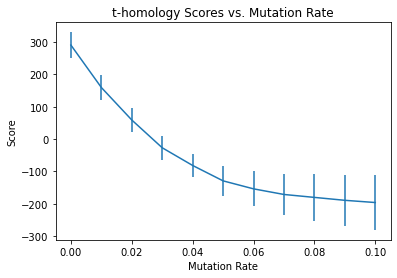

In [48]:
from matplotlib import pyplot as plt
from numpy import mean, std

rates = sorted(scores.keys())
plt.errorbar(rates, [mean(scores[r]) for r in rates], yerr=[std(scores[r]) for r in rates])    
plt.title("t-homology Scores vs. Mutation Rate")
plt.xlabel("Mutation Rate")
plt.ylabel("Score")
plt.show()

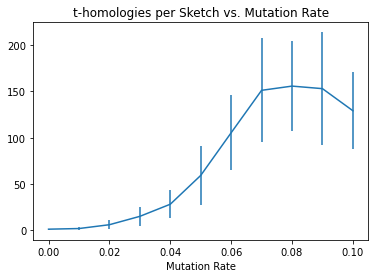

In [49]:
rates = sorted(homsPerPair.keys())
plt.errorbar(rates, [mean(homsPerPair[r]) for r in rates], yerr=[std(homsPerPair[r]) for r in rates])    
plt.title("t-homologies per Sketch vs. Mutation Rate")
plt.xlabel("Mutation Rate")
plt.show()

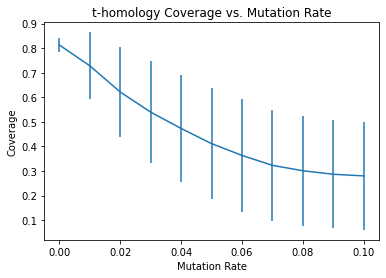

In [50]:
rates = sorted(percCovs.keys())
plt.errorbar(rates, [mean(percCovs[r]) for r in rates], yerr=[std(percCovs[r]) for r in rates])    
plt.title("t-homology Coverage vs. Mutation Rate")
plt.xlabel("Mutation Rate")
plt.ylabel("Coverage")
plt.show()

Mutation rate: 0.0


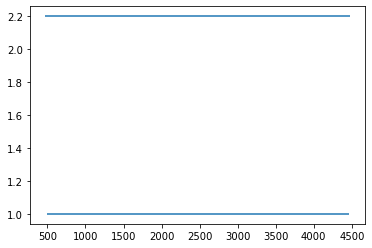

Mutation rate: 0.01


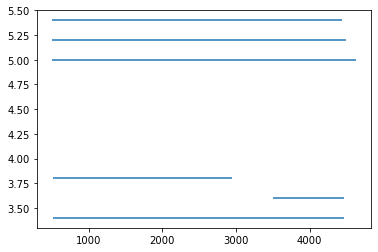

Mutation rate: 0.02


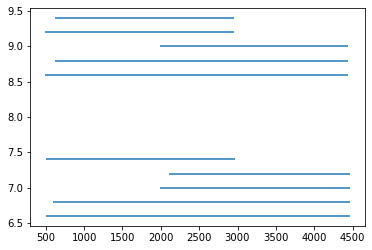

Mutation rate: 0.03


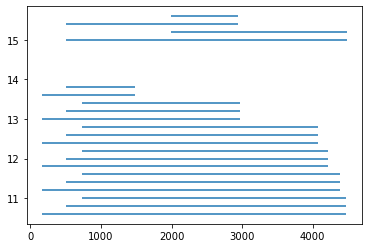

Mutation rate: 0.04


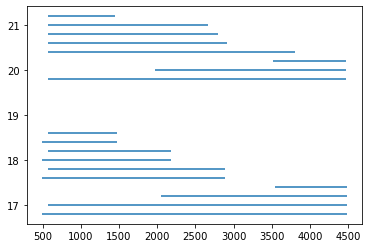

Mutation rate: 0.05


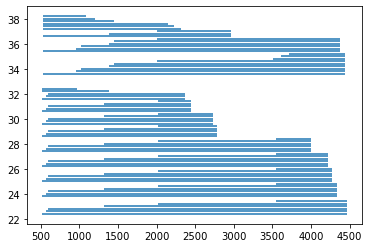

Mutation rate: 0.06


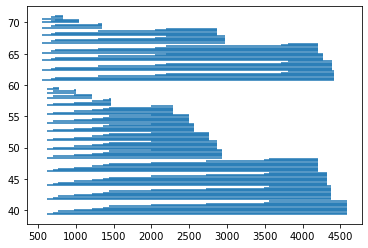

Mutation rate: 0.07


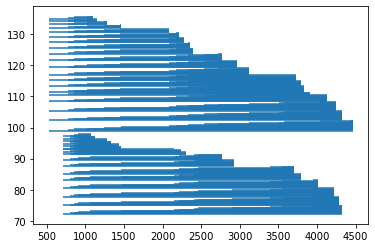

Mutation rate: 0.08


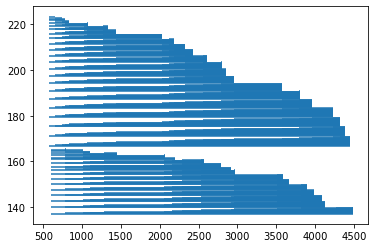

Mutation rate: 0.09


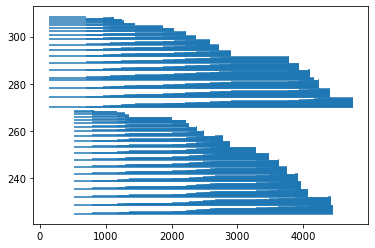

Mutation rate: 0.1


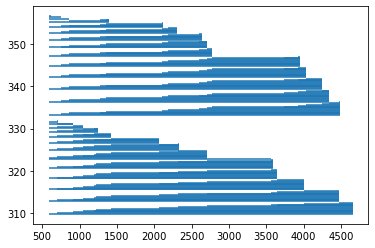

In [61]:
mRates = sorted(coords.keys())
maxY = 1.
padding = 0.2

for m in mRates:
    print("Mutation rate:", m)
    
    for p in coords[m][:2]:
        plt.hlines([maxY + i * padding for i in range(len(p))], [t[0] for t in p], [t[1] for t in p])
        maxY += 1. + padding * len(p)
        
    plt.show()

In [42]:
mean(homsPerPair[0.01])

2.12

In [43]:
mean(homsPerPair[0.02])

6.24

In [45]:
mean(homsPerPair[])

KeyError: 0.0